# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# reading csv files and seperating labels from features 

In [2]:
tr_df=pd.read_csv('train_data.csv')
ts_df=pd.read_csv('test_data.csv')
tr_df=tr_df.drop(columns=["ID"])
ts_df=ts_df.drop(columns=["ID"])
X_train=tr_df.drop(columns=['Segmentation'])
y_train=tr_df['Segmentation']
X_test=ts_df.drop(columns=["Segmentation"])
y_test=ts_df["Segmentation"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5333, 9), (1333, 9), (5333,), (1333,))

# encoding string features to int

In [3]:
label_encoders = {}
#creating new encodings and encoding traiing data
for col in X_train.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])  # Fit and transform training data
    label_encoders[col] = le  # Store the encoder for future use
#using encoder to encode test data
for col in X_test.select_dtypes(include=["object"]).columns:
    if col in label_encoders:  # Ensure the same encoder is used
        X_test[col] = label_encoders[col].transform(X_test[col])

# training the model

In [4]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [5]:
#testing data accuracy
from sklearn.metrics import accuracy_score, classification_report
testpred=rfc.predict(X_test)
print(accuracy_score(testpred,y_test))
testconfi=rfc.predict_proba(X_test)

print("shape of testconfi array is: ",testconfi.shape)
testconfi.max(axis=1)

0.49212303075768943
shape of testconfi array is:  (1333, 4)


array([0.62      , 0.47      , 1.        , ..., 0.77333333, 0.89      ,
       0.41      ])

In [6]:
#training data accuracy
trainpred=rfc.predict(X_train)
print(accuracy_score(trainpred,y_train))
trainconfi=rfc.predict_proba(X_train)

print("shape of testconfi array is: ",trainconfi.shape)
trainconfi.max(axis=1)

0.9613725857866117
shape of testconfi array is:  (5333, 4)


array([0.66      , 0.734     , 0.78616667, ..., 0.91      , 0.98      ,
       0.90466667])

# checking confidence on all combinations for data leak

In [7]:
query_df=pd.read_csv("query_data.csv")
query_df=query_df.drop(columns=["ID"])
print(query_df)
for col in query_df.select_dtypes(include=["object"]).columns:
    if col in label_encoders:  # Ensure the same encoder is used
        query_df[col] = label_encoders[col].transform(query_df[col])
print(rfc.predict(query_df))
query_confi=rfc.predict_proba(query_df)
print(query_confi.max(axis=1))


   Gender Ever_Married  Age Graduated Profession  Work_Experience  \
0    Male          Yes   35       Yes     Artist              9.0   
1    Male          Yes   35       Yes     Artist              9.0   
2    Male          Yes   35       Yes     Artist              9.0   
3    Male          Yes   35       Yes     Artist              9.0   
4    Male          Yes   35       Yes     Artist              9.0   
5    Male          Yes   35       Yes     Artist              9.0   
6    Male          Yes   35       Yes     Artist              9.0   
7    Male          Yes   35       Yes     Artist              9.0   
8    Male          Yes   35       Yes     Artist              9.0   
9    Male          Yes   35       Yes     Artist              9.0   
10   Male          Yes   35       Yes     Artist              9.0   
11   Male          Yes   35       Yes     Artist              9.0   
12   Male          Yes   35       Yes     Artist              9.0   
13   Male          Yes   35       

In [8]:
newtrain=pd.read_csv('newtrain.csv')
newtrainlabels=newtrain['Segmentation']
newtrain=newtrain.drop(columns=['ID','Segmentation'])
for col in newtrain.select_dtypes(include=["object"]).columns:
    if col in label_encoders:  # Ensure the same encoder is used
        newtrain[col] = label_encoders[col].transform(newtrain[col])


# training without the query datapoint

In [9]:
rfc2 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc2.fit(newtrain, newtrainlabels)


RandomForestClassifier(random_state=42)

# verifying with query datapoint not in training dataset

In [10]:
print(rfc2.predict(query_df))
query_confi2=rfc2.predict_proba(query_df)
print(query_confi2.max(axis=1))


['A' 'A' 'A' 'A' 'C' 'C' 'A' 'A' 'B' 'B' 'B' 'C' 'C' 'C' 'C' 'C' 'B' 'B'
 'C' 'C' 'C']
[0.52166667 0.52166667 0.48416667 0.38416667 0.39733333 0.42816667
 0.41433333 0.36       0.35       0.4        0.39       0.4
 0.545      0.435      0.34       0.48       0.415      0.375
 0.57466667 0.87216667 0.72966667]


<hr>


## Adding noise to output

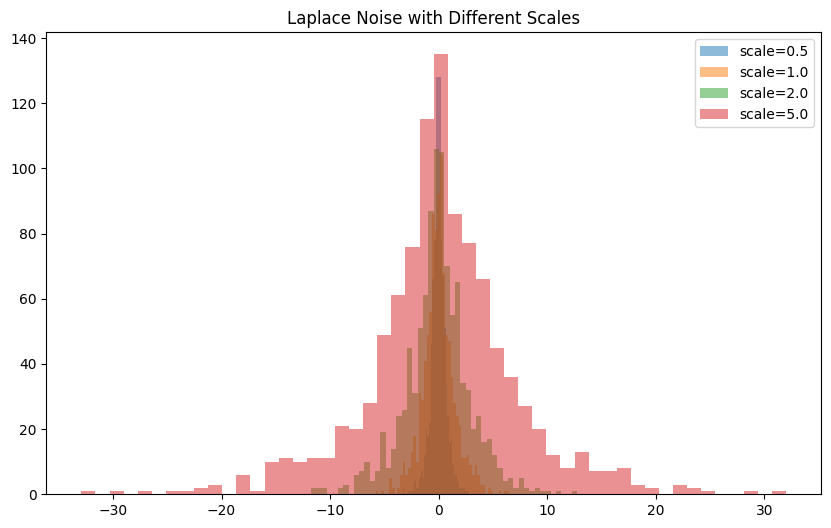

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Compare different scale values
x = np.linspace(-10, 10, 1000)
scales = [0.5, 1.0, 2.0, 5.0]

plt.figure(figsize=(10, 6))
for scale in scales:
    noise = np.random.laplace(0, scale, 1000)
    plt.hist(noise, bins=50, alpha=0.5, label=f'scale={scale}')
plt.legend()
plt.title('Laplace Noise with Different Scales')
plt.show()

In [12]:
print(query_confi)
#A B C D are corresponding to index 0,1,2,3 respectively in confidence matrix

[[0.52333333 0.17333333 0.22333333 0.08      ]
 [0.53333333 0.22333333 0.20333333 0.04      ]
 [0.47333333 0.22333333 0.23333333 0.07      ]
 [0.36333333 0.17333333 0.31333333 0.15      ]
 [0.3275     0.14333333 0.41916667 0.11      ]
 [0.3135     0.16333333 0.46316667 0.06      ]
 [0.381      0.20333333 0.35566667 0.06      ]
 [0.36       0.31       0.24       0.09      ]
 [0.33       0.34       0.26       0.07      ]
 [0.24       0.36       0.31       0.09      ]
 [0.17       0.36       0.32       0.15      ]
 [0.15       0.3        0.44       0.11      ]
 [0.14       0.25333333 0.59666667 0.01      ]
 [0.18       0.19       0.61       0.02      ]
 [0.3        0.29       0.36       0.05      ]
 [0.16       0.33       0.47       0.04      ]
 [0.21       0.42       0.3        0.07      ]
 [0.12       0.36       0.38       0.14      ]
 [0.05       0.23533333 0.60466667 0.11      ]
 [0.02       0.10116667 0.87883333 0.        ]
 [0.07       0.02533333 0.90466667 0.        ]]


### same noise to all classes

In [21]:
indtoclass={0:'A',
           1:'B',
           2:'C',
           3: 'D'}
def class_prediction(matrix):
    """
    Returns the indices of the maximum value in each row of a 2D NumPy array.

    Parameters:
        matrix (np.ndarray): A 2D NumPy array.

    Returns:
        np.ndarray: A 1D array of column indices of the maximum value in each row.
    """
    arr=np.argmax(matrix, axis=1)
    temp=[]
    for i in arr:
        temp+=indtoclass[i]
    return temp


In [13]:
import numpy as np

def add_laplace_noise(data, scale):
    """
    Add Laplace noise to data array
    
    Args:
    data: array of values
    sensitivity: float value
    epsilon: float value
    
    Returns: array with added Laplace noise
    """
    noise = np.random.laplace(0, scale, size=len(data))
    return data + noise

In [49]:

for i in query_confi:
    temp=add_laplace_noise(i,3)
    add=sum(temp)
    for j in range (len(temp)):
        temp[j]=temp[j]/add
    temp = np.clip(temp, 0.01, 0.99)
    print(temp) 
    

[0.25089012 0.16213104 0.10216767 0.48481117]
[0.03311665 0.71334077 0.01       0.27383553]
[0.21675703 0.33190826 0.52705693 0.01      ]
[0.26733018 0.01       0.89788569 0.20484847]
[0.99 0.99 0.01 0.01]
[0.25212182 0.61908565 0.91735332 0.01      ]
[0.53849059 0.05206063 0.13607789 0.27337089]
[0.01 0.99 0.01 0.01]
[0.01 0.99 0.01 0.01]
[0.99 0.01 0.01 0.01]
[0.21191324 0.43864616 0.33578524 0.01365536]
[0.01       0.5418781  0.40549427 0.48218733]
[0.55576445 0.01       0.21284821 0.2704244 ]
[0.01       0.31202587 0.12140988 0.99      ]
[0.43774853 0.01       0.28311556 0.28372317]
[0.03139825 0.99       0.01       0.30909986]
[0.08724544 0.40197417 0.3586406  0.1521398 ]
[0.01       0.99       0.01       0.28787739]
[0.1130654  0.57337578 0.2456637  0.06789512]
[0.67260724 0.318991   0.27022129 0.01      ]
[0.99 0.01 0.01 0.99]


In [50]:
import numpy as np

def add_laplace_noise_to_proba(proba_array, scale=0.1):
    """
    Adds Laplace noise to the prediction probabilities.
    The same noise is added to all class probabilities for a single data point.

    Args:
        proba_array (np.ndarray): Original prediction probabilities, shape (n_samples, n_classes)
        scale (float): Scale of the Laplace noise (larger means more noise)

    Returns:
        np.ndarray: Noisy, normalized probabilities of same shape, rounded to 6 decimal places
    """
    n_samples, n_classes = proba_array.shape

    # Generate one noise value per sample
    laplace_noise = np.abs(np.random.laplace(loc=0.0, scale=scale, size=(n_samples, 1)))

    # Add the same noise across all class probs for each sample
    noisy_proba = proba_array + laplace_noise

    # Ensure no negative values
    noisy_proba = np.clip(noisy_proba, 1e-8, None)

    # Normalize so each row sums to 1
    noisy_proba /= noisy_proba.sum(axis=1, keepdims=True)

    # Round to 6 decimal places
    noisy_proba = np.round(noisy_proba, 6)

    return noisy_proba


In [51]:
probs_n2=add_laplace_noise_to_proba(query_confi,scale=0.05)
new_pred_n2=(class_prediction(add_laplace_noise_to_proba(trainconfi,scale=0.05)))

print(probs_n2)
print(accuracy_score(new_pred_n2,trainpred))

[[0.397992 0.20849  0.235562 0.157956]
 [0.519692 0.224617 0.20558  0.05011 ]
 [0.446682 0.226516 0.235322 0.09148 ]
 [0.30527  0.212611 0.280886 0.201232]
 [0.306598 0.172102 0.373541 0.147759]
 [0.298258 0.184136 0.412    0.105606]
 [0.34812  0.215046 0.329145 0.107688]
 [0.353158 0.306268 0.240622 0.099952]
 [0.31469  0.322776 0.258086 0.104448]
 [0.243255 0.324195 0.29047  0.14208 ]
 [0.172924 0.355979 0.317441 0.153655]
 [0.171891 0.289055 0.398408 0.140647]
 [0.154275 0.252901 0.551679 0.041146]
 [0.182321 0.191989 0.598064 0.027626]
 [0.294825 0.28586  0.348615 0.070701]
 [0.17912  0.313004 0.423262 0.084613]
 [0.217442 0.388373 0.290698 0.103488]
 [0.129689 0.351802 0.370311 0.148198]
 [0.077643 0.23736  0.555647 0.12935 ]
 [0.102562 0.154593 0.653104 0.089741]
 [0.139776 0.112424 0.650889 0.096911]]
1.0


In [17]:
#not very effective, more like a roulette subtraction of noise from lower one increases the confidence of higher one

In [18]:
# Optimized DP Noise Function
def add_dp_noise(probabilities, epsilon=3.0):
    """
    Improved noise function that:
    - Only affects predictions with confidence ≥0.8
    - Uses proper sensitivity (2.0)
    - Minimizes accuracy impact
    """
    noisy_probs = probabilities.copy()
    sensitivity = 2.0
    
    for i in range(len(probabilities)):
        conf = probabilities[i].max()
        if conf >= 0.8:
            scale = sensitivity / epsilon
            # Directional noise that primarily reduces confidence
            noise = np.random.laplace(0, scale, size=probabilities.shape[1])
            predicted_class = np.argmax(probabilities[i])
            noise[predicted_class] = -abs(noise[predicted_class])  # Reduce confidence
            
            noisy_probs[i] = probabilities[i] + noise
            noisy_probs[i] = np.clip(noisy_probs[i], 0.01, 0.99)
            noisy_probs[i] /= noisy_probs[i].sum()
    
    return noisy_probs



In [47]:
new_predic_n1=class_prediction(add_dp_noise(trainconfi,3))
confi_n1=add_dp_noise(query_confi,1)
print(accuracy_score(new_predic_n1,trainpred))
print(confi_n1)

0.7039189949371836
[[0.52333333 0.17333333 0.22333333 0.08      ]
 [0.53333333 0.22333333 0.20333333 0.04      ]
 [0.47333333 0.22333333 0.23333333 0.07      ]
 [0.36333333 0.17333333 0.31333333 0.15      ]
 [0.3275     0.14333333 0.41916667 0.11      ]
 [0.3135     0.16333333 0.46316667 0.06      ]
 [0.381      0.20333333 0.35566667 0.06      ]
 [0.36       0.31       0.24       0.09      ]
 [0.33       0.34       0.26       0.07      ]
 [0.24       0.36       0.31       0.09      ]
 [0.17       0.36       0.32       0.15      ]
 [0.15       0.3        0.44       0.11      ]
 [0.14       0.25333333 0.59666667 0.01      ]
 [0.18       0.19       0.61       0.02      ]
 [0.3        0.29       0.36       0.05      ]
 [0.16       0.33       0.47       0.04      ]
 [0.21       0.42       0.3        0.07      ]
 [0.12       0.36       0.38       0.14      ]
 [0.05       0.23533333 0.60466667 0.11      ]
 [0.40918607 0.00424956 0.16585786 0.42070651]
 [0.02298637 0.93104089 0.02298637 0.0229